# Topic extraction of merkel speeches

# About
This notebook explores the capabilities to extract topics from political speeches of Angela Merkel. LSI and LDA are used to extract topics.
Speeches are processed with tokenization, lemmatization, stop_words, filtering of part-of-speech-tags and n-grams.

In Addition TF-IDF mesaure is used to weight the terms for LSI.

There are a lot of other models and approaches which aren't covered by now, but maybe they will.

## Libraries

In [34]:
from nltk.stem.snowball import SnowballStemmer
from stop_words import get_stop_words
from nltk import ngrams
#from gensim.models import TfidfModel

from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

import gensim
import nltk
import spacy
import pandas as pd

## Read Merkel speeches

Todo:
- Create additional columns for DataFrame like year, then it will be possible to detect topics by year for further investigation

In [23]:
with open('all_speeches', "r") as f:
    speeches = f.read()
    speeches = [ speech for speech in speeches.split('\n') ]

df_speeches = pd.DataFrame(data=speeches, columns=["speech"])

## Global variables - stemmer, stop word list

In [27]:
stop_words = get_stop_words('de')
stemmer = SnowballStemmer("german")
nlp = spacy.load("de")

for sw in stop_words:
    w = nlp.vocab[sw]
    w.is_stop

## Preprocessing functions

In [28]:
# preprocess_sw_lemma_nouns
# The following steps are executed for a speach
# 1. tokenization
# 2. lemmatization 
# 3. stop word removal
# 4. filtering nouns
def preprocess_sw_lemma_nouns(speech):
    tokens = nltk.word_tokenize(speech)
    doc = nlp(speech)
    result = [token.lemma_ for token in doc if not token.is_stop and token.pos_ == "NOUN"
             and not token.text == "Herren" and not token.text == "Damen"
             and not token.text == "Herr" and not token.text == "Frau"]
    
    return result

# preprocess_ngrams
# generates bigrams from tokens
# e.g.: "Sehr" "geehrte" will be transformed to "Sehr_geehrte"
def preprocess_ngrams(tokens, n_grams=2):
    grams = nltk.ngrams(tokens, n_grams)
    return ["_".join(gram) for gram in grams]

# preprocess_basic
# The following steps are executed for a speech
# 1. tokenization
# 2. lemmatization 
# 3. stop word removal
# 4. excule multiple part-of-speech tags
def preprocess_basic(speech):
    tokens = nltk.word_tokenize(speech)
    doc = nlp(speech)
    result = [token.lemma_ for token in doc if not token.is_stop and 
              not token.pos_ == "SYM" and not token.pos_ == "PRON" and not token.pos_ == "NUM" and 
              not token.pos_ == "DET" and not token.pos_ == "CONJ" and not token.pos_ == "PUNCT" and
              not token.pos_ == "ADV" and not token.text == "Herren" and not token.text == "Damen" and
              not token.text == "Herr" and not token.text == "Frau" and
              token.is_alpha]
    return result

## Perform preprocessing step

In [29]:
text_data = []
for speech in speeches:
    preprocessed_speech = preprocess_sw_lemma_nouns(speech)
   # preprocessed_speech = preprocess_ngrams(preprocessed_speech)
    text_data.append(preprocessed_speech)

## Generate dictionary and corpus

In [30]:
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(speech) for speech in text_data]

## Optional - save corpus and dictionary

In [31]:
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

## Evaluation of multiple models by coherence score and perplexity

Multiple models are generated and compared by their coherence score and perplexity. The number of topics have a big influence of these metrics. num_topics can be chosen by the optimal setting of these parameter or explorative.

TODO: 
- replace - gensim provides function to execute different model to retrieve the "best" model
- better evaluation with Cross-Validation

In [35]:
import warnings; warnings.simplefilter('ignore')

MIN_NUM_TOPICS = 3
MAX_NUM_TOPICS = 15

results = []
#lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary)
#lda_model.save("merkel_lda.gensim")

compare = pd.DataFrame(columns=["number_of_topics", "coherence_score", "perplexity"])
compare.number_of_topics = compare.number_of_topics.astype(int)

lda_models = {}

for number_of_topics in range(MIN_NUM_TOPICS, MAX_NUM_TOPICS+1):
    lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=number_of_topics, id2word=dictionary)
    topics = lda_model.print_topics(num_words=10)
    
    perplexity_score = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=text_data, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
    
    compare = compare.append({'number_of_topics':number_of_topics, 
                              'coherence_score':coherence, 
                              'perplexity':perplexity_score}, 
                             ignore_index=True)
    
    lda_models[str(number_of_topics)] = lda_model
    #print(topics)

## Plotting

Text(0, 0.5, 'perplexity_score')

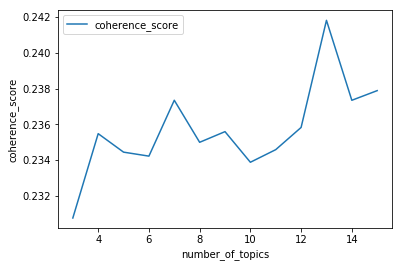

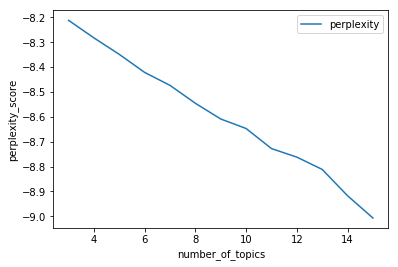

In [49]:
import matplotlib.pyplot as plt

plt.show()

plt = compare.plot(x="number_of_topics", y="coherence_score")
plt.set_ylabel('coherence_score')

plt = compare.plot(x="number_of_topics", y="perplexity")
plt.set_ylabel('perplexity_score')

In [53]:
best_model_key = "13" # best model

# Part two - use TFIDF to enhance results

In this part we are using TF-IDF value to "enhance" our documents. The use of this metric can improve the results of the extracted topics. 
https://en.wikipedia.org/wiki/Tf–idf .

## Generate TF-IDF based corpus and model

In [54]:
tfidf_model = gensim.models.TfidfModel(corpus)
print(tfidf_model)
tfidf_corpus = tfidf_model[corpus]

TfidfModel(num_docs=826, num_nnz=170786)


# Part three - Visualization

TODO:
- color highlighting for words in speeches to the corresponding topics

In [77]:
import pyLDAvis.gensim
pd.set_option('display.max_colwidth', -1)

In [78]:
lsi = gensim.models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=13)
lsi_corpus = lsi[tfidf_corpus]
lsi_topics = lsi.print_topics(13)
lsi_result = pd.DataFrame(columns=['topic_number', 'words'])
for topic_number, words in lsi_topics:
    lsi_result = lsi_result.append({"topic_number":topic_number, "words":words}, ignore_index=True)

lsi_result
    

,topic_number,words
0,0,"0.120*""Jahr"" + 0.118*""Union"" + 0.108*""Unternehmen"" + 0.106*""Land"" + 0.105*""Prozent"" + 0.103*""Frage"" + 0.097*""Thema"" + 0.096*""Mensch"" + 0.091*""Bereich"" + 0.090*""Wirtschaft"""
1,1,"0.176*""Freiheit"" + 0.145*""Vertriebene"" + 0.130*""Friede"" + 0.123*""Vertreibung"" + -0.122*""Unternehmen"" + 0.120*""Geschichte"" + 0.116*""Versöhnung"" + -0.115*""Energie"" + 0.109*""Antisemitismus"" + 0.108*""Freundschaft"""
2,2,"-0.932*""Mai"" + -0.150*""Frau"" + -0.084*""Familie"" + -0.060*""Kind"" + -0.059*""Mann"" + 0.053*""Union"" + -0.050*""berufen"" + -0.041*""Gesellschaft"" + -0.038*""Behinderung"" + -0.036*""alt"""
3,3,"0.395*""Frau"" + -0.351*""Mai"" + 0.238*""Familie"" + 0.172*""Kind"" + 0.158*""Mann"" + -0.135*""Union"" + 0.129*""berufen"" + 0.115*""Gesellschaft"" + 0.106*""Behinderung"" + 0.094*""Eltern"""
4,4,"-0.301*""messen"" + -0.157*""Wissenschaft"" + -0.155*""Unternehmen"" + 0.148*""Flüchtling"" + -0.141*""Industrie"" + -0.141*""Forschung"" + -0.127*""Premierminister"" + -0.122*""Aussteller"" + 0.100*""Banken"" + -0.099*""Professor"""
5,5,"-0.315*""Nachhaltigkeit"" + -0.226*""Frau"" + -0.188*""zielen"" + -0.148*""Energie"" + -0.147*""Klimaschutz"" + 0.143*""messen"" + -0.117*""Nation"" + -0.109*""Klimawandel"" + -0.107*""Konferenz"" + -0.098*""Agenda"""
6,6,"0.388*""Frau"" + -0.259*""Vertriebene"" + -0.183*""Vertreibung"" + -0.154*""Flüchtling"" + 0.151*""Mann"" + -0.129*""Flucht"" + 0.119*""Krise"" + -0.116*""Nachhaltigkeit"" + -0.113*""Behinderung"" + 0.111*""Freiheit"""
7,7,"-0.282*""Flüchtling"" + 0.166*""Vertriebene"" + -0.163*""Frau"" + -0.143*""Digitalisierung"" + 0.120*""Wachstum"" + -0.120*""Außengrenzen"" + 0.116*""Energie"" + 0.113*""Nachhaltigkeit"" + -0.107*""Migration"" + 0.105*""Banken"""
8,8,"-0.416*""Vertriebene"" + -0.360*""Frau"" + -0.306*""Vertreibung"" + -0.200*""Flucht"" + 0.172*""Behinderung"" + -0.117*""Versöhnung"" + -0.113*""Mann"" + 0.105*""Freiheit"" + -0.104*""Heimatvertriebenen"" + -0.100*""Heimat"""
9,9,"0.318*""messen"" + -0.226*""Forschung"" + -0.226*""Wissenschaft"" + -0.150*""Universität"" + 0.128*""Antisemitismus"" + -0.123*""Professor"" + 0.121*""Nachhaltigkeit"" + 0.121*""Aussteller"" + -0.117*""Flüchtling"" + -0.115*""Forscher"""


In [80]:
lda_result = pd.DataFrame(columns=['topic_number', 'words'])
lda_topics = lda_models[best_model_key].print_topics(num_words=10)
for topic_number, words in lda_topics:
    lda_result = lda_result.append({"topic_number":topic_number, "words":words}, ignore_index=True)
lda_result

,topic_number,words
0,0,"0.011*""Land"" + 0.011*""Mensch"" + 0.010*""Jahr"" + 0.007*""Frage"" + 0.006*""Beispiel"" + 0.006*""Welt"" + 0.005*""Unternehmen"" + 0.005*""Prozent"" + 0.005*""Entwicklung"" + 0.004*""Bundesregierung"""
1,1,"0.020*""Jahr"" + 0.016*""Land"" + 0.012*""Mensch"" + 0.010*""Frage"" + 0.008*""Welt"" + 0.006*""Unternehmen"" + 0.005*""Thema"" + 0.005*""Beispiel"" + 0.005*""Prozent"" + 0.005*""Staat"""
2,2,"0.019*""Land"" + 0.014*""Jahr"" + 0.012*""Mensch"" + 0.008*""Frage"" + 0.007*""Beispiel"" + 0.007*""Welt"" + 0.006*""Union"" + 0.005*""Zeit"" + 0.005*""Weg"" + 0.004*""Zukunft"""
3,3,"0.016*""Jahr"" + 0.014*""Land"" + 0.012*""Mensch"" + 0.009*""Frage"" + 0.006*""Beispiel"" + 0.005*""Staat"" + 0.005*""Bundesregierung"" + 0.005*""Zeit"" + 0.005*""Zukunft"" + 0.004*""Welt"""
4,4,"0.017*""Jahr"" + 0.015*""Land"" + 0.014*""Mensch"" + 0.010*""Frage"" + 0.007*""Welt"" + 0.006*""Beispiel"" + 0.006*""Entwicklung"" + 0.005*""Prozent"" + 0.005*""Zukunft"" + 0.005*""Bundesregierung"""
5,5,"0.017*""Jahr"" + 0.015*""Mensch"" + 0.011*""Land"" + 0.010*""Frage"" + 0.008*""Welt"" + 0.006*""Beispiel"" + 0.006*""Thema"" + 0.006*""Zeit"" + 0.006*""Bereich"" + 0.005*""Unternehmen"""
6,6,"0.022*""Jahr"" + 0.016*""Land"" + 0.011*""Mensch"" + 0.007*""Entwicklung"" + 0.007*""Frage"" + 0.007*""Welt"" + 0.006*""Zeit"" + 0.006*""Staat"" + 0.006*""Thema"" + 0.006*""Union"""
7,7,"0.021*""Jahr"" + 0.014*""Land"" + 0.010*""Mensch"" + 0.008*""Beispiel"" + 0.007*""Frage"" + 0.007*""Welt"" + 0.006*""Thema"" + 0.006*""Weg"" + 0.005*""Unternehmen"" + 0.005*""Prozent"""
8,8,"0.016*""Land"" + 0.015*""Jahr"" + 0.010*""Mensch"" + 0.006*""Beispiel"" + 0.005*""Entwicklung"" + 0.005*""Frage"" + 0.005*""Weg"" + 0.005*""Thema"" + 0.004*""Welt"" + 0.004*""Zukunft"""
9,9,"0.017*""Jahr"" + 0.015*""Mensch"" + 0.011*""Land"" + 0.009*""Frage"" + 0.006*""Beispiel"" + 0.006*""Welt"" + 0.006*""Prozent"" + 0.006*""Thema"" + 0.005*""Zeit"" + 0.005*""Staat"""


In [ ]:
lda_display = pyLDAvis.gensim.prepare(lda_models[best_model_key], corpus, dictionary, sort_topics=True, mds='tsne')
pyLDAvis.display(lda_display)

In [59]:
#lda_tfidf = gensim.models.ldamodel.LdaModel(tfidf_corpus, num_topics=10, id2word=dictionary)
#lda_tfidf_display = pyLDAvis.gensim.prepare(lda_tfidf, tfidf_corpus, dictionary, sort_topics=False)
#pyLDAvis.display(lda_tfidf_display)